In [6]:
%load_ext memory_profiler
import os
import tensorflow as tf
import warnings
import numpy as np
import pandas as pd
import scanpy as sc

warnings.simplefilter(action='ignore', category=FutureWarning)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

from scgamnn import scGAMNN
from utils import *
from metrics import *
warnings.filterwarnings("ignore")

sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=100)
sc.settings.set_figure_params(dpi_save=300)
sc.logging.print_version_and_date()

adata1  = sc.read_csv("E:/scGAMNN/data/mouse-human/Data1.csv")
adata2 = sc.read_csv("E:/scGAMNN/data/mouse-human/Data2.csv")
adata = adata1.concatenate(adata2)
ident1 = pd.read_csv("E:/scGAMNN/data/mouse-human/label1.csv")
ident2 = pd.read_csv("E:/scGAMNN/data/mouse-human/label2.csv")
idents = np.vstack((ident1, ident2))
adata.obs['celltype'] = idents
match = np.array(pd.read_csv("E:/scGAMNN/data/mouse-human/match.csv"))
adata.obs["batch"] = np.array([0] * len(ident1) + [1] * len(ident2))
sc.pp.normalize_per_cell(adata)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=2000, flavor='seurat_v3',batch_key='batch')
adata = adata[:,adata.var['highly_variable']]
sc.pp.scale(adata, max_value=10)
adatas = [adata[adata.obs['batch'] == i, :].copy() for i in [0,1]]
scaledata = adata.X
adj, adj_n = construct_graph(adatas, match)

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler
Running Scanpy 1.9.1, on 2023-07-13 12:09.
normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


In [7]:
model = scGAMNN(scaledata, adj, adj_n, match=match,hidden_dim=120, latent_dim=50, decA="DBL", layer_enc="GCN")

import time
time_s = time.time()
%memit model.train(epochs=200, W_a=1, W_x=1, W_w=0.05)
print('time used:', time.time()-time_s)

Epoch 1  X_rec_loss: 0.7592177   A_rec_loss: 0.4161165   MNN_loss: 0.4161165  total_loss:  1.2929994
Learning rate = 0.0020000
Epoch 2  X_rec_loss: 0.752735   A_rec_loss: 0.20722033   MNN_loss: 0.20722033  total_loss:  1.0758198
Learning rate = 0.0020000
Epoch 3  X_rec_loss: 0.7459458   A_rec_loss: 0.07978845   MNN_loss: 0.07978845  total_loss:  0.9449842
Learning rate = 0.0020000
Epoch 4  X_rec_loss: 0.7348079   A_rec_loss: 0.014727458   MNN_loss: 0.014727458  total_loss:  0.8740582
Learning rate = 0.0020000
Epoch 5  X_rec_loss: 0.720849   A_rec_loss: 0.0019859036   MNN_loss: 0.0019859036  total_loss:  0.8521261
Learning rate = 0.0020000
Epoch 6  X_rec_loss: 0.7083801   A_rec_loss: 0.0010344988   MNN_loss: 0.0010344988  total_loss:  0.8416819
Learning rate = 0.0020000
Epoch 7  X_rec_loss: 0.6961197   A_rec_loss: 0.0009266088   MNN_loss: 0.0009266088  total_loss:  0.82990634
Learning rate = 0.0020000
Epoch 8  X_rec_loss: 0.68879104   A_rec_loss: 0.00092660903   MNN_loss: 0.00092660903 

Epoch 62  X_rec_loss: 0.6063406   A_rec_loss: 0.0010834227   MNN_loss: 0.0010834227  total_loss:  0.6475164
Learning rate = 0.0012800
Epoch 63  X_rec_loss: 0.6054377   A_rec_loss: 0.0010851416   MNN_loss: 0.0010851416  total_loss:  0.64609605
Learning rate = 0.0012800
Epoch 64  X_rec_loss: 0.60452133   A_rec_loss: 0.001090607   MNN_loss: 0.001090607  total_loss:  0.644689
Learning rate = 0.0012800
Epoch 65  X_rec_loss: 0.60359836   A_rec_loss: 0.0010996774   MNN_loss: 0.0010996774  total_loss:  0.6433016
Learning rate = 0.0012800
Epoch 66  X_rec_loss: 0.6026732   A_rec_loss: 0.0011095596   MNN_loss: 0.0011095596  total_loss:  0.64192975
Learning rate = 0.0012800
Epoch 67  X_rec_loss: 0.6017713   A_rec_loss: 0.0011184603   MNN_loss: 0.0011184603  total_loss:  0.64057386
Learning rate = 0.0012800
Epoch 68  X_rec_loss: 0.60089886   A_rec_loss: 0.0011268695   MNN_loss: 0.0011268695  total_loss:  0.63923746
Learning rate = 0.0012800
Epoch 69  X_rec_loss: 0.60003126   A_rec_loss: 0.001133998

computing neighbors
    using data matrix X directly
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:18)


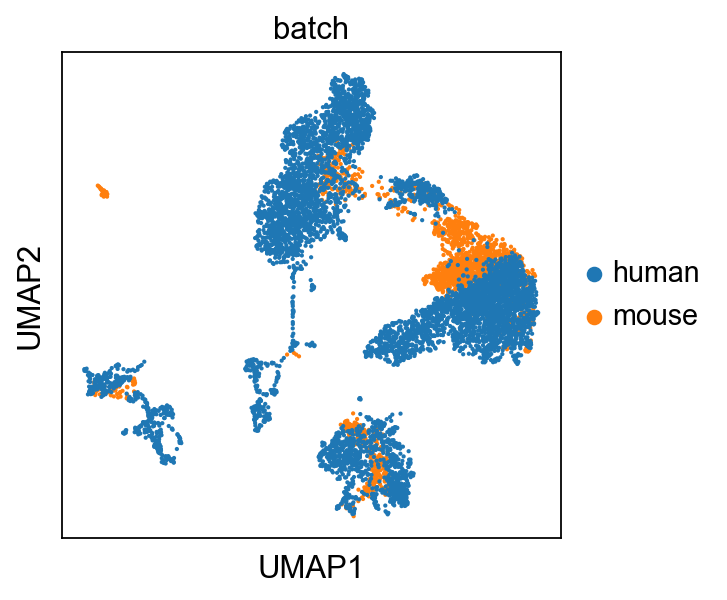

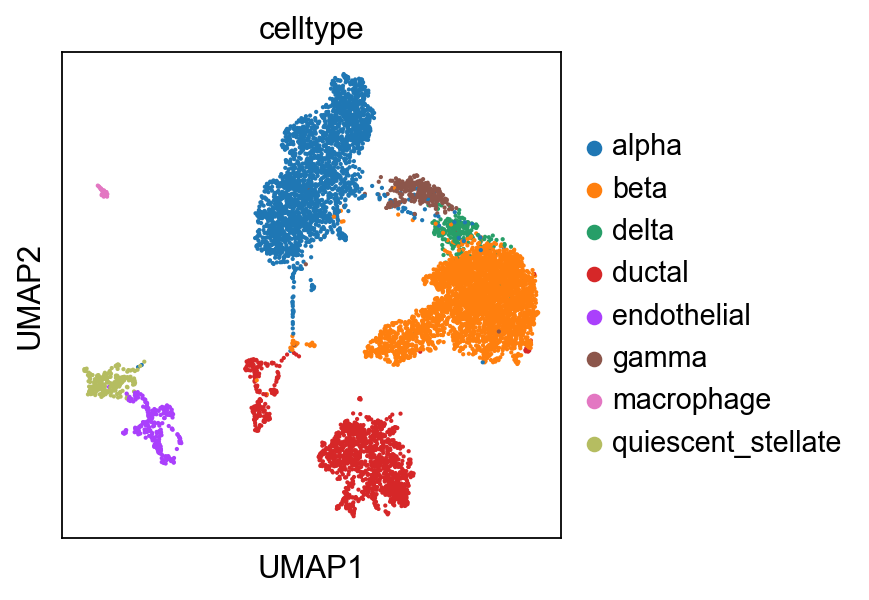

In [8]:
import anndata as ad
adata_scGAMNN=ad.AnnData(model.embedding(scaledata, adj_n))
sc.pp.neighbors(adata_scGAMNN)
sc.tl.umap(adata_scGAMNN)
adata_scGAMNN.obs['celltype'] = adata.obs['celltype'].to_list()
adata_scGAMNN.obs['batch'] = ['mouse' if i == 0 else 'human' for i in adata.obs['batch']]
sc.pl.umap(adata_scGAMNN, color='batch')
sc.pl.umap(adata_scGAMNN, color='celltype')

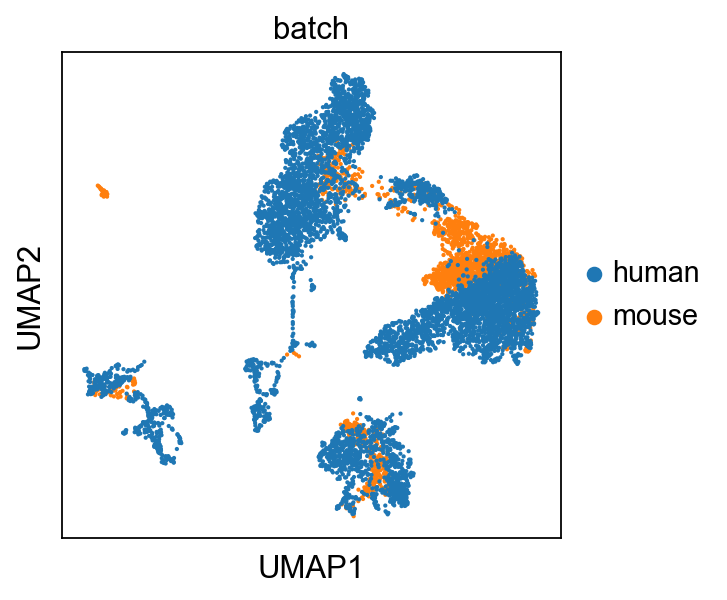

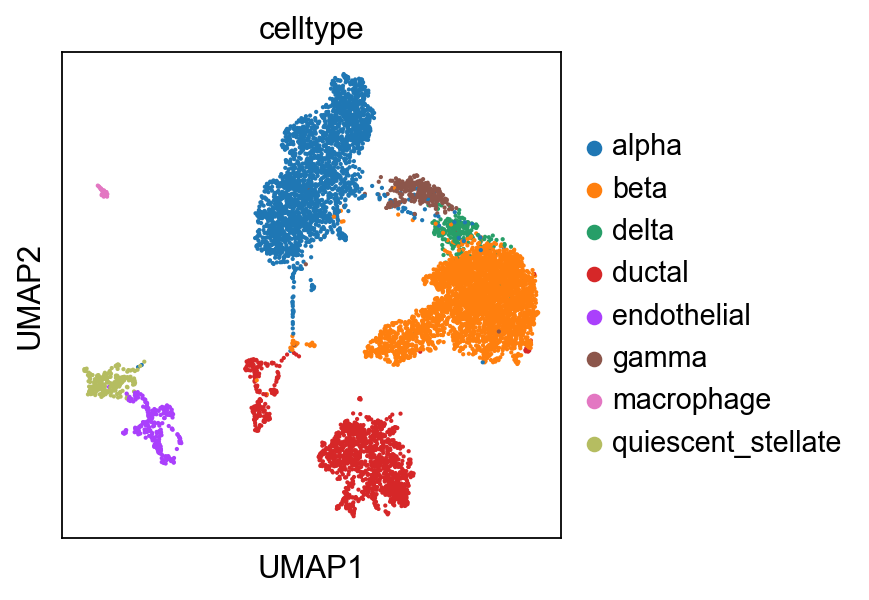

In [11]:
sc.pl.umap(adata_scGAMNN,color='batch',save='_mh_scGAMNN_batch.pdf')
sc.pl.umap(adata_scGAMNN,color='celltype',save='_mh_scGAMNN_celltype.pdf')

In [9]:
inte_scGAMNN=integrate_indicators (np.array(adata_scGAMNN.obsm['X_umap']),np.array(adata_scGAMNN.obs['batch']),np.array(adata_scGAMNN.obs['celltype']))
inte_scGAMNN_df=pd.DataFrame.from_dict(inte_scGAMNN,orient='index').T

integrate ASW_c: 0.6803 ASW_b: 0.8846 


In [10]:
#8-------------------------
sc.tl.leiden(adata_scGAMNN,resolution=0.12)
cluster_scGAMNN=cluster_indicators (adata_scGAMNN.obs['leiden'],np.array(adata_scGAMNN.obs['celltype']))
cluster_scGAMNN_df=pd.DataFrame.from_dict(cluster_scGAMNN,orient='index').T

running Leiden clustering
    finished: found 8 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
cluster nmi: 0.8699 ari: 0.8989 


In [12]:

inte_scGAMNN_df.to_csv('result/inte_scGAMNN_mh.csv',index=0)
cluster_scGAMNN_df.to_csv('result/c_scGAMNN_mh.csv',index=0)

In [13]:
adata_scGAMNN.write('result/adata_scGAMNN_mh.h5ad')
#adata_scGAMNN= sc.read_h5ad('result/adata_scGAMNN_mh.h5ad')


In [14]:
entropy_scGAMNN=compute_entropy(adata_scGAMNN)
entropy_scGAMNN.to_csv('result/entropy_scGAMNN_mh.csv',index=0)

Calculating entropy ...
use exist neighbors
Entropy calculated!
